# Rocket League Notebook 2: EDA, Kitchen Sink

## Goals 

- Get familiar with Rocket League training data
- Create a giant, kitchen-sink model with all (or just all numerical) columns
- Create every possible single-variable model and identify the highest performers
- Create a model using only n highest performers

## Results

- Kitchen Sink model trained by the mean of the matches data
    - Accuracy: 0.55
- Kitchen Sink model trained on the raw matches data
    - Accuracy: 0.49
- Univariate Analysis (Manual)
    | rank | feature | accuracy |
    | ---- | ------- | -------- |
    | 1. | percent_supersonic_speed	| 0.399947 |
    | 2. | bcpm	| 0.372195 | 
    | 3. | percent_ground | 0.359713| 
    | 4. | percent_low_air | 0.355995| 
    | 5. | time_supersonic_speed | 	0.349489| 
    | 6. | bpm	| 0.341256 | 
    | 7. | avg_speed_percentage	| 0.339397| 
    | 8. | avg_powerslide_duration | 0.337140| 
    | 9. | count_powerslide	| 0.320143| 
    | 10. | saves | 0.300491| 
    | 11. | percent_slow_speed | 0.299695| 
    | 12. | percent_boost_75_100	| 0.298898| 
- Univariate Analysis (sklearn)
    - 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Converter

In [2]:
converter = { 'bronze': 1, 'silver': 2, 'gold': 3, 'platinum': 4, 'diamond': 5, 'champion': 6 }

## Read In

In [3]:
matches = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [4]:
# train['rank'] = pd.Categorical(train['rank'], [
#     "bronze",
#     "silver",
#     "gold",
#     "platinum",
#     "diamond",
#     "champion"
# ])

## Build a kitchen-sink model

In [5]:
matches_prepped = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0)

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped[['rank']]


pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter = 1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))


Accuracy Score:  0.5529146195724339
Confusion Matrix: 
 [[  55    0    2   27    7   93]
 [   0 1020  399    2   49    0]
 [   1  403  832   35  456    2]
 [   8    0   53  920  444  138]
 [   2   37  416  414  995   11]
 [  26    1    4  304   33  342]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.60      0.30      0.40       184
    champion       0.70      0.69      0.70      1470
     diamond       0.49      0.48      0.48      1729
        gold       0.54      0.59      0.56      1563
    platinum       0.50      0.53      0.52      1875
      silver       0.58      0.48      0.53       710

    accuracy                           0.55      7531
   macro avg       0.57      0.51      0.53      7531
weighted avg       0.55      0.55      0.55      7531



In [6]:
pipeline.fit(X, y.values.ravel())
test_prep = test.groupby(['match_id']).mean().fillna(0)
y_pred = pipeline.predict(test_prep)
y_pred = pd.Series(y_pred).map(converter)
submission = pd.concat([test_prep.reset_index()['match_id'], y_pred], axis = 1).rename(columns = {0: 'rank'})

In [7]:
submission

,match_id,rank
0,30121,5
1,30122,3
2,30123,4
3,30124,4
4,30125,5
...,...,...
2495,32616,3
2496,32617,6
2497,32618,5
2498,32619,3


In [8]:
submission.to_csv("../submissions/submission_2022-03-25_v1.csv", index = False)

## Run a similar model to the one above; however, don't aggregate the training data in advance. (Though we do have to aggregate or cut down the test data.)

Performance is not improved. I wonder if taking the mean initially cuts down on variation.

In [9]:
X = matches.drop(columns = ['match_id', 'rank', 'color', 'car_name', 'map_code']).fillna(0)
y = matches[['rank']]


pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter = 1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))


Accuracy Score:  0.49306154969789523
Confusion Matrix: 
 [[  68    2   11   67   19  202]
 [   0 1889  803   14  230    3]
 [   2  822 1493  147  992    2]
 [  21   33  207 1622  996  247]
 [   9  169  865  869 1811   26]
 [  31    5   18  674  149  543]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.52      0.18      0.27       369
    champion       0.65      0.64      0.64      2939
     diamond       0.44      0.43      0.44      3458
        gold       0.48      0.52      0.50      3126
    platinum       0.43      0.48      0.46      3749
      silver       0.53      0.38      0.44      1420

    accuracy                           0.49     15061
   macro avg       0.51      0.44      0.46     15061
weighted avg       0.50      0.49      0.49     15061



## Find the best single-column performers
## ('Univariate Analysis')

In [10]:
drop_cols = ['match_id', 'rank', 'color', 'map_code', 'car_name']

In [11]:
drop_cols = ['match_id', 'rank', 'color', 'map_code', 'car_name']
cols = []
scores = []
for col in matches.drop(columns = drop_cols):
   matches_prepped = matches.groupby(['match_id', 'rank'])[col].mean().reset_index().fillna(0)

   X = matches_prepped.drop(columns = ['match_id', 'rank'])
   y = matches_prepped['rank']

   X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

   logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

   y_pred = logreg.predict(X_test)

   cols.append(col)
   scores.append(accuracy_score(y_test, y_pred))


In [12]:
singleModelScores = pd.DataFrame({'variable': cols, 'score':scores})
singleModelScores.nlargest(12, 'score')

,variable,score
54,percent_supersonic_speed,0.399947
13,bcpm,0.372195
55,percent_ground,0.359713
56,percent_low_air,0.355995
42,time_supersonic_speed,0.349489
12,bpm,0.341256
51,avg_speed_percentage,0.339397
50,avg_powerslide_duration,0.337140
49,count_powerslide,0.320143
7,saves,0.300491


<AxesSubplot:>

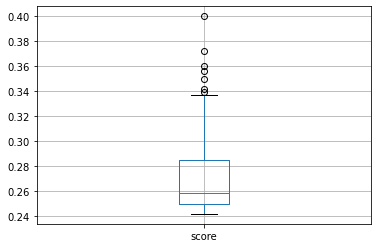

In [13]:
singleModelScores.boxplot()

## Let's try a model with just these outlier ones together.

Not better than the kitchen sink.

In [14]:
singleModelOutliers = singleModelScores.nlargest(8, 'score')['variable'].to_list()

matches_prepped = matches.groupby(['match_id', 'rank'])[singleModelOutliers].mean().reset_index().fillna(0)

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped[['rank']]


pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter = 1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy Score:  0.4608949674677998
Confusion Matrix: 
 [[ 17   1   1  46  14 105]
 [  0 901 414  11 141   3]
 [  2 474 673  70 510   0]
 [  7  30 124 749 537 116]
 [  6 120 439 425 874  11]
 [  9   3  14 350  77 257]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.41      0.09      0.15       184
    champion       0.59      0.61      0.60      1470
     diamond       0.40      0.39      0.40      1729
        gold       0.45      0.48      0.47      1563
    platinum       0.41      0.47      0.43      1875
      silver       0.52      0.36      0.43       710

    accuracy                           0.46      7531
   macro avg       0.47      0.40      0.41      7531
weighted avg       0.46      0.46      0.46      7531



Are these top 8 correlated? Yes.

In [15]:
df = matches[singleModelOutliers]
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
rho.round(2).astype(str) + p

,percent_supersonic_speed,bcpm,percent_ground,percent_low_air,time_supersonic_speed,bpm,avg_speed_percentage,avg_powerslide_duration
percent_supersonic_speed,1.0***,0.69***,-0.48***,0.47***,0.75***,0.68***,0.8***,-0.27***
bcpm,0.69***,1.0***,-0.4***,0.38***,0.54***,0.9***,0.69***,-0.28***
percent_ground,-0.48***,-0.4***,1.0***,-0.94***,-0.4***,-0.42***,-0.48***,0.31***
percent_low_air,0.47***,0.38***,-0.94***,1.0***,0.4***,0.38***,0.46***,-0.3***
time_supersonic_speed,0.75***,0.54***,-0.4***,0.4***,1.0***,0.53***,0.6***,-0.22***
bpm,0.68***,0.9***,-0.42***,0.38***,0.53***,1.0***,0.67***,-0.26***
avg_speed_percentage,0.8***,0.69***,-0.48***,0.46***,0.6***,0.67***,1.0***,-0.35***
avg_powerslide_duration,-0.27***,-0.28***,0.31***,-0.3***,-0.22***,-0.26***,-0.35***,1.0***


### Refine above with interactions

A little better, but not outstanding.

In [16]:
singleModelOutliers = singleModelScores.nlargest(8, 'score')['variable'].to_list()

matches_prepped = matches.groupby(['match_id', 'rank'])[singleModelOutliers].mean().reset_index().fillna(0)

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped[['rank']]

pf = PolynomialFeatures(interaction_only = True, include_bias = False)

pipeline = Pipeline(steps = [
    ('scaler', RobustScaler()),
    ('pf', pf),
    ('logreg', LogisticRegression(max_iter = 1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy Score:  0.4635506572832293
Confusion Matrix: 
 [[ 30   1   2  36  11 104]
 [  0 877 430  12 149   2]
 [  1 442 674  78 533   1]
 [  6  27 126 764 495 145]
 [  6 108 440 447 860  14]
 [ 16   2  12 318  76 286]]
Classification Report: 
               precision    recall  f1-score   support

      bronze       0.51      0.16      0.25       184
    champion       0.60      0.60      0.60      1470
     diamond       0.40      0.39      0.39      1729
        gold       0.46      0.49      0.47      1563
    platinum       0.40      0.46      0.43      1875
      silver       0.52      0.40      0.45       710

    accuracy                           0.46      7531
   macro avg       0.48      0.42      0.43      7531
weighted avg       0.47      0.46      0.46      7531



## Univariate Analysis using sklearn

This is the same Kitchen Sink function from the top. We want to use sklearn resources to identify the top n features in this model.

In [17]:
matches_prepped = matches.groupby(['match_id', 'rank']).mean().reset_index().fillna(0)

X = matches_prepped.drop(columns = ['match_id', 'rank'])
y = matches_prepped[['rank']]


pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter = 1000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

pipeline.fit(X_train, y_train.values.ravel())

y_pred = pipeline.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))


Accuracy Score:  0.5529146195724339


Now that we have this model, we can use sklearn to extract features.

In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

k_list = []
accuracy_list = []

for k in np.arange(1, 86):

    X_new = SelectKBest(f_classif, k = k).fit_transform(X, y)

    pipeline = Pipeline(steps = [
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter = 1000))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=42, stratify=y)

    pipeline.fit(X_train, y_train.values.ravel())

    y_pred = pipeline.predict(X_test)

    k_list.append(k)
    accuracy_list.append(accuracy_score(y_test, y_pred))

C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [8] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jrior\anaconda3\lib\site-packages\sklearn\feature_selection\_univari

In [27]:
d = {'k': k_list, 'accuracy': accuracy_list}
k_scores = pd.DataFrame(d)

<AxesSubplot:xlabel='k', ylabel='accuracy'>

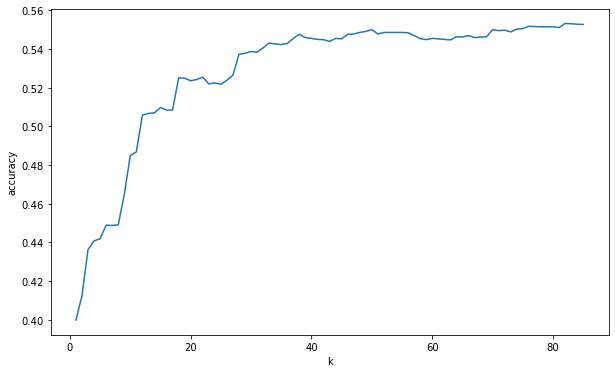

In [31]:
plt.subplots(figsize = (10,6))
sns.lineplot(x = 'k', y = 'accuracy', data = k_scores)

Looks like the magic number here is 17 features.

In [36]:
k_scores.nsmallest(25, 'k')

,k,accuracy
0,1,0.399947
1,2,0.412429
2,3,0.436330
3,4,0.440845
4,5,0.441907
5,6,0.448944
6,7,0.448812
7,8,0.449077
8,9,0.464746
9,10,0.484929
